# やること

- 実機データを GRU だけで学習させる
- vC の波形のスイッチングノイズ部分を削って学習させる


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
from torchview import draw_graph

from src.utils.load_data import load_data, path_list
from src.utils.models import BuckConverterCell, GRUModel
from src.utils.plot_data import plot_iLvC


# 乱数固定用の処理
seed = 10
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

np.random.seed(seed)

In [2]:
keep_log = False  # 結果保存するかどうか

# 真値パラメータ（すべてのデータセットで共通）
L_true: float = 223.6e-6
C_true: float = 73.8e-6
R_true: float = 5

Vin = 10
Vref = 5
duty = Vref / Vin
f_sw = 1e5  # スイッチング周波数
T = 1 / f_sw  # 1周期の実時間

train_ratio = 0.3
valid_ratio = 0.3
# test_ratio = 1 - train_ratio - valid_ratio

# 学習パラメータ
L_init = 200e-6
C_init = 100e-6
R_init = 8.0

# 異なるパラメータに異なる学習率を設定
lr_L = 5e-2
lr_C = 1e-2
lr_R = 2e-2

epochs = 1000

# GRU学習用のデータ準備（時系列データ）
seq_length = 10

gru_lr = 0.001
gru_epochs = 200


# 実機データの確認


In [3]:
data2_t, data2_iL, data2_vC = load_data(
    path=path_list.path2,
    downsample_step=1,
    start_time=0,
)
data3_t, data3_iL, data3_vC = load_data(
    path=path_list.path3,
    downsample_step=1,
    start_time=0,
)

print(f"{len(data2_t)=}")
print(f"{len(data2_iL)=}")
print(f"{len(data2_vC)=}")

print(f"{len(data3_t)=}")
print(f"{len(data3_iL)=}")
print(f"{len(data3_vC)=}")


len(data2_t)=883625
len(data2_iL)=883625
len(data2_vC)=883625
len(data3_t)=1000000
len(data3_iL)=1000000
len(data3_vC)=1000000


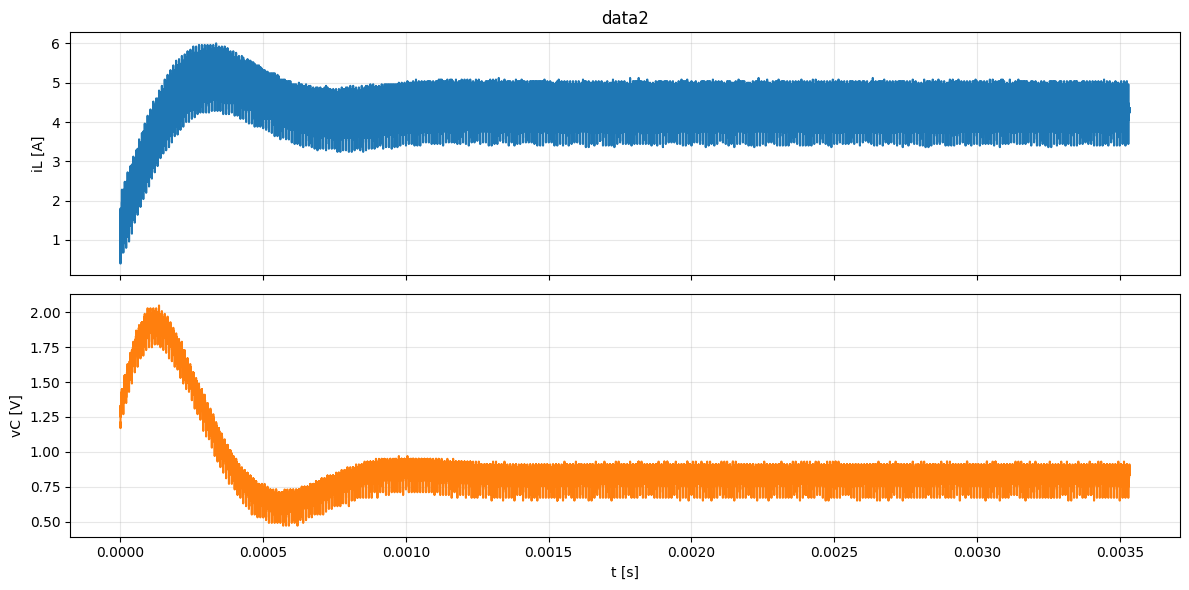

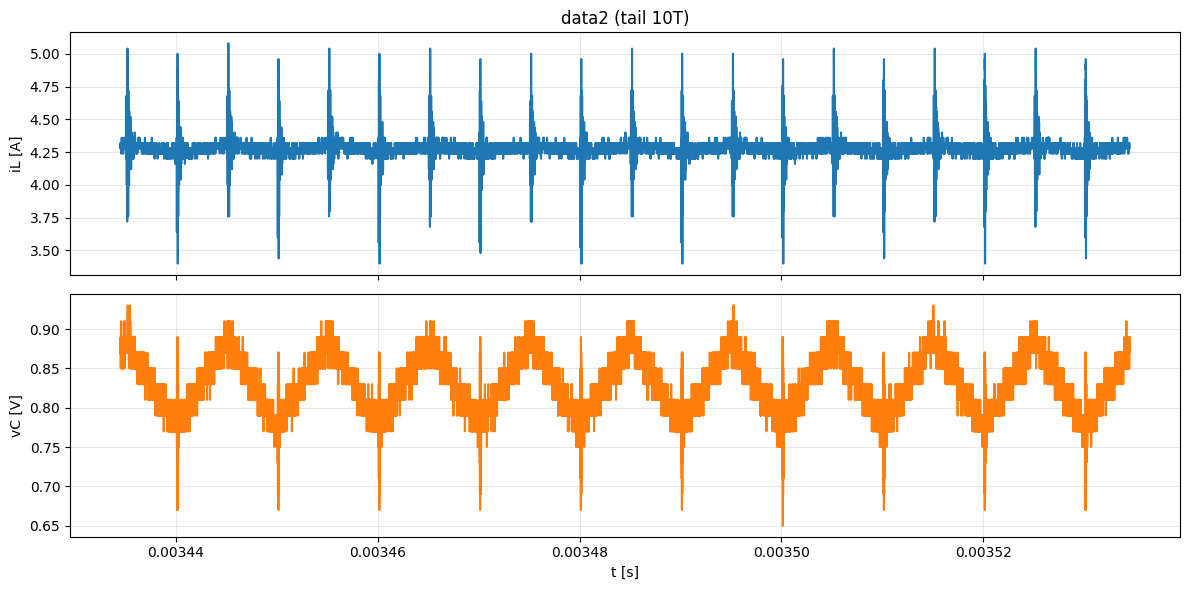

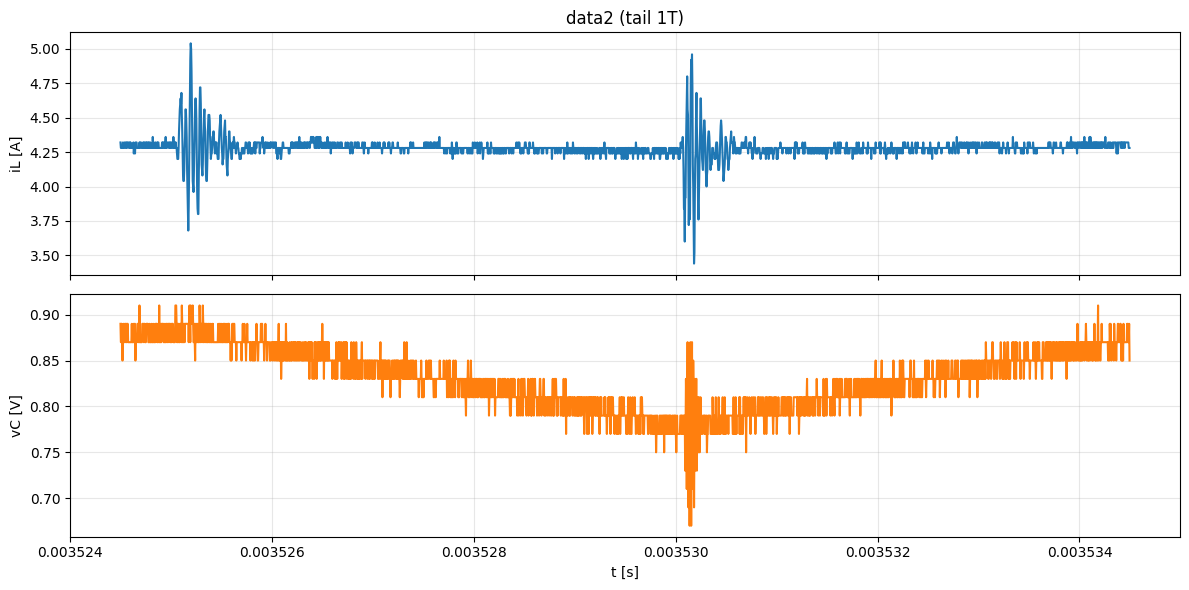

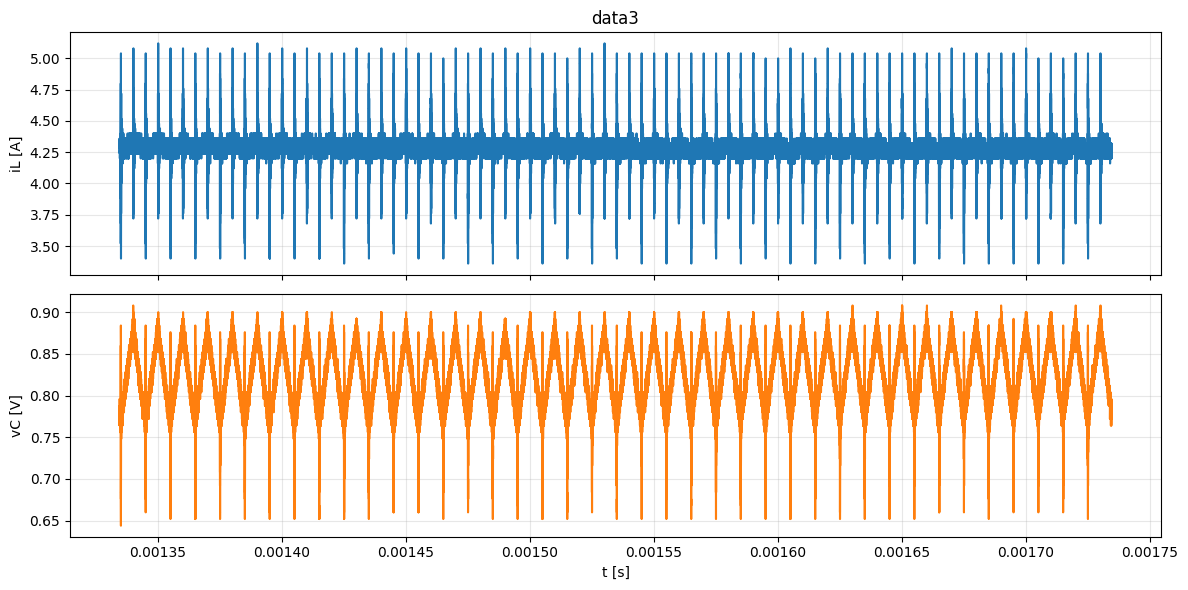

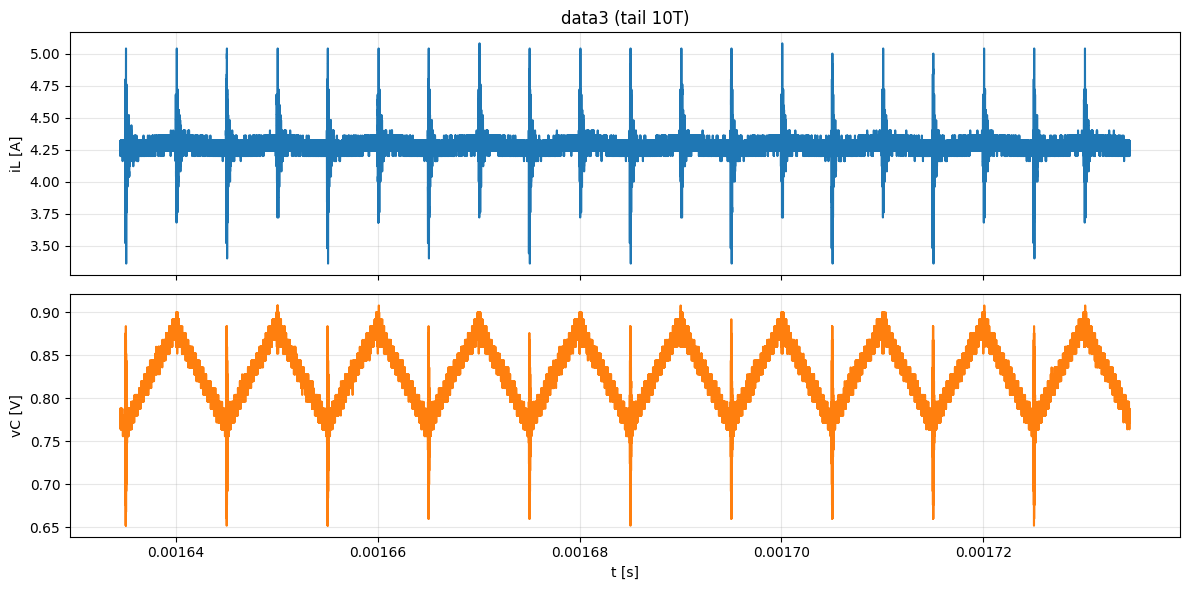

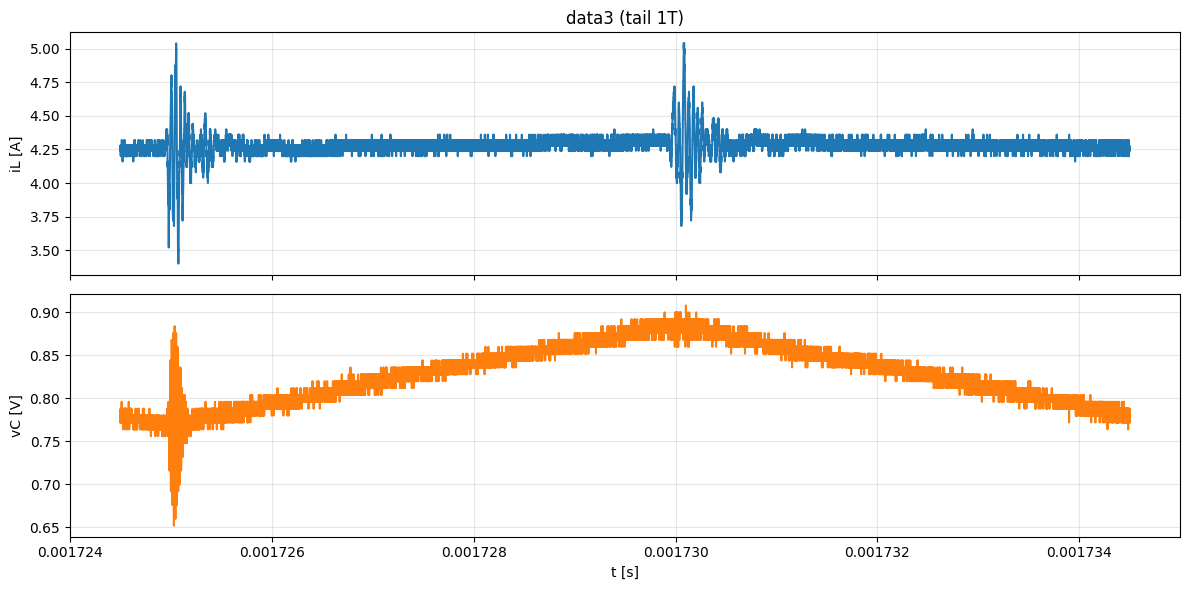

In [4]:
plot_iLvC(data2_t, data2_iL, data2_vC, T=T, title="data2")
plot_iLvC(data3_t, data3_iL, data3_vC, T=T, title="data3")
plt.show()


# シミュレーション波形と比較